# Leven at Newby Bridge using HBV model in eWaterCycle

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#general python
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

#niceties
from rich import print

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## set up paths

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"
forcing_path.mkdir(exist_ok=True)

# choose region
We have to pick a region where to run the model, in order to generate forcing inputs for the model. Of course, we choose the region where we are organising this workshop: "Leven at Newby Bridge"

In [4]:
camelsgb_id = "camelsgb_73010"

In [7]:
forcing_path_basin = forcing_path / camelsgb_id 
forcing_path_basin.mkdir(exist_ok=True)

forcing_path_caravan = forcing_path_basin / "caravan"
forcing_path_caravan.mkdir(exist_ok=True)

forcing_path_era5 = forcing_path_basin / "era5"
forcing_path_era5.mkdir(exist_ok=True)

## add parameter info

Array of initial storage terms - we keep these constant for now: <br>
                Si,  Su, Sf, Ss


In [8]:
s_0 = np.array([0,  100,  0,  5, 0])

Array of parameters min/max bounds as a reference: <br>
Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks

In [9]:
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

Set initial as mean of max,min

In [10]:
par_0 = (p_min_initial + p_max_initial)/2

Specify start and end date

In [11]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"
HRU_id = 1620500
alpha = 1.2626

## Forcing

In [12]:
#from ewatercycle_HBV.forcing import HBVForcing

we use camels forcing as an example, which is fully integrated [Newman, 2014](https://gdex.ucar.edu/dataset/camels.html). The seperate text file is hosted [here](https://github.com/Daafip/Msc-Thesis-Notebooks/blob/4735392c4f15af29f433e87491d65668e89663b5/Forcing/01620500_lump_cida_forcing_leap.txt) for easy access without having to download the whole dataset (13gb). 

In [13]:
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(start_time = experiment_start_date,
                                                               end_time = experiment_end_date,
                                                               directory = forcing_path,
                                                               basin_id = camelsgb_id,
                                                                 )


In [14]:
print(camelsgb_forcing)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/repos/eurocsdms_ewatercycle_workshop/book/oneModel/Forcing'),
    shape=PosixPath('/home/rhut/repos/eurocsdms_ewatercycle_workshop/book/oneModel/Forcing/camelsgb_73010.shp'),
    filenames={
        'evspsblpot': 'camelsgb_73010_1997-08-01_2000-08-31_evspsblpot.nc',
        'pr': 'camelsgb_73010_1997-08-01_2000-08-31_pr.nc',
        'tas': 'camelsgb_73010_1997-08-01_2000-08-31_tas.nc',
        'tasmin': 'camelsgb_73010_1997-08-01_2000-08-31_tasmin.nc',
        'Q': 'camelsgb_73010_1997-08-01_2000-08-31_Q.nc',
        'tasmax': 'camelsgb_73010_1997-08-01_2000-08-31_tasmax.nc'
    }
)

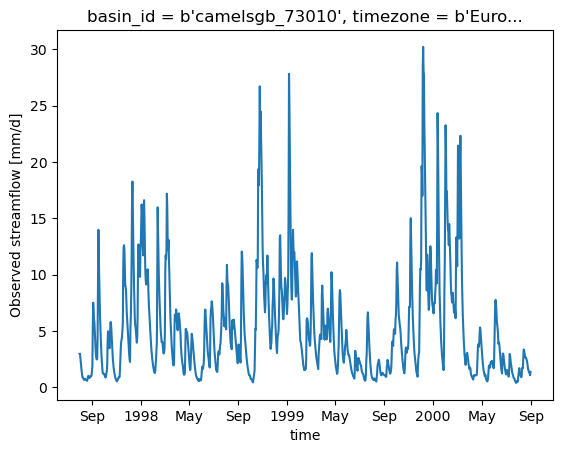

In [15]:
camelsgb_forcing.to_xarray()['Q'].plot()

In [16]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
    dataset="ERA5",
    start_time=experiment_start_date,
    end_time=experiment_end_date,
    shape=camelsgb_forcing.shape,
    directory=forcing_path
)

In [17]:
#camels_forcing = HBVForcing(start_time = experiment_start_date,
#                          end_time = experiment_end_date,
#                          directory = forcing_path,
#                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
#                          alpha= alpha
#                          )

## Setting up the model

In [18]:
model = ewatercycle.models.HBV(forcing = ERA5_forcing)

In [19]:
config_file = model.setup(
            parameters=','.join([str(p) for p in par_0]),
    initial_storage=','.join([str(s) for s in s_0]),
           )

In [20]:
model.initialize(config_file)

## Running model

In [22]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

After running the model: finalize to shut everything down

In [23]:
model.finalize()

## Process results

In [24]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

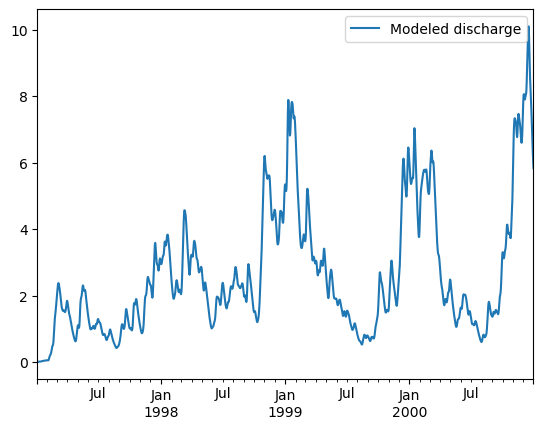

In [25]:
fig, ax = plt.subplots(1,1)
df.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.legend(bbox_to_anchor=(1,1));